In [1]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py
import geopandas as gpd
os.sys.path.append(os.path.join(os.getcwd(),r'..\standard'))
import os, sys
sys.path.append(os.path.join(os.getcwd(),r'..\..\..'))
# import summary_helpers

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs'
survey_path = '../../../inputs/base_year/survey'

In [3]:
pd.options.display.float_format = '{:0,.0f}'.format

In [4]:
def load_network_summary(filepath):
    """Load network-level results using a standard procedure. """
    df = pd.read_csv(filepath)

    # Congested network components by time of day
    df.columns

    # Get freeflow from 20to5 period

    # Exclude trips taken on non-designated facilities (facility_type == 0)
    # These are artificial (weave lanes to connect HOV) or for non-auto uses 
    df = df[df['data3'] != 0]    # data3 represents facility_type

    # calculate total link VMT and VHT
    df['VMT'] = df['@tveh']*df['length']
    df['VHT'] = df['@tveh']*df['auto_time']/60

    # Define facility type
    df.loc[df['data3'].isin([1,2]), 'facility_type'] = 'highway'
    df.loc[df['data3'].isin([3,4,6]), 'facility_type'] = 'arterial'
    df.loc[df['data3'].isin([5]), 'facility_type'] = 'connector'

    # Calculate delay
    # Select links from overnight time of day
    delay_df = df.loc[df['tod'] == '20to5'][['ij','auto_time']]
    delay_df.rename(columns={'auto_time':'freeflow_time'}, inplace=True)

    # Merge delay field back onto network link df
    df = pd.merge(df, delay_df, on='ij', how='left')

    # Calcualte hourly delay
    df['total_delay'] = ((df['auto_time']-df['freeflow_time'])*df['@tveh'])/60    # sum of (volume)*(travtime diff from freeflow)

    df['county'] =df['@countyid'].map({33: 'King',
                                      35: 'Kitsap',
                                      53: 'Pierce',
                                      61: 'Snohomish'})
    
    return df

# Truck Miles Traveled by Type
Daily Total

In [5]:
df = load_network_summary(os.path.join(relative_path,'network',r'network_results.csv'))

In [6]:
_df = df.groupby('county').sum()[['@medium_truck','@heavy_truck']]
_df.loc['Total',:] = _df.sum()
_df = _df.reset_index()
_df.rename(columns={'county':'County', '@medium_truck': 'Medium Trucks', '@heavy_truck': 'Heavy Trucks'}, inplace=True)
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\RTP','truck_vmt.csv'))
HTML(_df.to_html(index=False))

County,Medium Trucks,Heavy Trucks
King,"16,234,940","9,436,417"
Kitsap,"861,910","410,603"
Pierce,"3,503,864","3,397,456"
Snohomish,"3,443,504","2,585,456"
Total,"24,044,218","15,829,932"


In [7]:
# Results by Congestion Level
df['speed'] = df['length']/df['auto_time']*60
df['congestion_index'] = df['speed']/df['data2']
df['congestion_index'] = df['congestion_index'].clip(0,1)
df['congestion_category'] = pd.cut(df['congestion_index'], bins=[0,.25,.5,.7,1], labels=['Severe','Heavy','Moderate','Light'])

AM Peak (5 - 9 am)

In [8]:
df['Medium and Heavy Trucks'] = df['@heavy_truck']+df['@medium_truck']

_df = df[df['tod'].isin(['5to6','6to7','7to8','8to9'])]
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='Medium and Heavy Trucks')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df.loc['Total',:] = _df.sum()
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\RTP','truck_vmt_am.csv'))
_df

,King,Kitsap,Pierce,Snohomish
Light,"3,838,159","236,261","1,109,414","1,024,461"
Moderate,"835,972","12,463","214,859","161,155"
Heavy,"751,361","10,571","128,183","113,974"
Severe,"170,918","4,568","37,586","21,493"
Total,"5,596,410","263,863","1,490,042","1,321,082"


PM Peak (3 - 6 pm)

In [9]:
_df = df[df['tod'].isin(['15to16','16to17','17to18'])]
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='Medium and Heavy Trucks')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df.loc['Total',:] = _df.sum()
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\RTP','truck_vmt_pm.csv'))
_df

,King,Kitsap,Pierce,Snohomish
Light,"3,044,037","203,625","871,108","809,373"
Moderate,"869,369","8,502","190,387","170,185"
Heavy,"725,798","6,712","167,938","129,828"
Severe,"198,284","4,759","35,559","22,797"
Total,"4,837,489","223,598","1,264,993","1,132,183"


# Share of Truck Miles by Truck Type
Daily Total

In [10]:
_df = df[['@medium_truck','@heavy_truck','county']].melt(
    id_vars='county', var_name='Truck Type')
_df = _df.pivot_table(index='Truck Type', columns='county', 
                values='value', aggfunc='sum')
_df.rename(index={'@heavy_truck': 'Heavy Trucks',
                 '@medium_truck': 'Medium Trucks'}, inplace=True)
_df.index.name = None
_df.columns.name = None
_df.sort_index(ascending=False, inplace=True)
_df_val = _df.copy()
_df.loc['Total',:] = _df.sum()
_df

,King,Kitsap,Pierce,Snohomish
Medium Trucks,"16,234,940","861,910","3,503,864","3,443,504"
Heavy Trucks,"9,436,417","410,603","3,397,456","2,585,456"
Total,"25,671,357","1,272,513","6,901,320","6,028,960"


In [11]:
pd.options.display.float_format = '{:0,.1%}'.format
_df_val/_df_val.sum()

,King,Kitsap,Pierce,Snohomish
Medium Trucks,63.2%,67.7%,50.8%,57.1%
Heavy Trucks,36.8%,32.3%,49.2%,42.9%


# Households Within 500' of Heaviest Volume Truck Routes
Heavest volume truck routes are defined as links where > 3.5% of traffic is from trucks.
This is roughly 10% of all network links. The plot shows the locations of these routes. **Note** this is only a prelimnary test of this analysis. 

<AxesSubplot:>

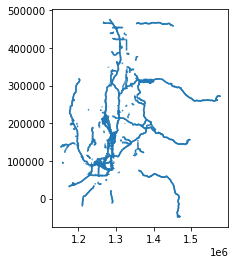

In [12]:
# People within 500' of High Volume Heavy Truck Route

# FIXME:
# Note that we should make this consistent across scenarios
# The links will change for each scenario because it's based off volumes
# We could just identify all of the freeway + major arterial streets or freight routes
# We should also flag the freight network 
# Did we ever flag that? 

# Intersect buffer with land use file
df_lu = pd.read_csv(r'..\..\..\inputs\scenario\landuse\parcels_urbansim.txt',
                   delim_whitespace=True)

# Load as a geodataframe
gdf_lu = gpd.GeoDataFrame(
    df_lu, geometry=gpd.points_from_xy(df_lu.XCOORD_P, df_lu.YCOORD_P))

crs = {'init' : 'EPSG:2285'}
gdf_lu.crs = crs

# Buffer the parcels at 500ft
gdf_lu['geometry'] = gdf_lu.buffer(500)

# Intersect geography this with the network shapefile
gdf_network = gpd.read_file(r'..\..\..\inputs\scenario\networks\shapefiles\AM\AM_edges.shp')
# Do not include connectors since these are abstracted ul3==5; also remove weave links ul3==0 
gdf_network = gdf_network[~gdf_network.ul3.isin([0,5])]

gdf_intersect = gpd.overlay(gdf_network, gdf_lu, how="intersection", keep_geom_type=False)

# Will need to relaculate the lengths since some were split across the regional geographies
gdf_intersect['new_length'] = gdf_intersect.geometry.length/5280.0

# filter out the polygon results and only keep lines
gdf_intersect = gdf_intersect[gdf_intersect.geometry.type.isin(['MultiLineString','LineString'])]

# Load as a geodataframe
gdf_lu = gpd.GeoDataFrame(
    df_lu, geometry=gpd.points_from_xy(df_lu.XCOORD_P, df_lu.YCOORD_P))

crs = {'init' : 'EPSG:2285'}
gdf_lu.crs = crs

# Buffer the parcels at 500ft
gdf_lu['geometry'] = gdf_lu.buffer(500)

# Intersect geography this with the network shapefile
gdf_network = gpd.read_file(r'..\..\..\inputs\scenario\networks\shapefiles\AM\AM_edges.shp')
# Do not include connectors since these are abstracted ul3==5; also remove weave links ul3==0 
gdf_network = gdf_network[~gdf_network.ul3.isin([0,5])]

gdf_intersect = gpd.overlay(gdf_network, gdf_lu, how="intersection", keep_geom_type=False)

# Will need to relaculate the lengths since some were split across the regional geographies
gdf_intersect['new_length'] = gdf_intersect.geometry.length/5280.0

# filter out the polygon results and only keep lines
gdf_intersect = gdf_intersect[gdf_intersect.geometry.type.isin(['MultiLineString','LineString'])]

# calculate the daily percent of trucks versus other vehicles for each link
# make sure none of these are connectors or weave links
_df = df[~df['data3'].isin([0,5])]
_df = df.groupby('ij').sum()[['@tveh','@heavy_truck','@medium_truck']]
_df['percent_heavy'] = _df['@heavy_truck']/_df['@tveh']

# Overall mean
_df['percent_heavy'].mean()

# Weighted mean?
(_df['percent_heavy']*_df['@tveh']).sum()/_df['@tveh'].sum()

# Links with heavy truck shares > 3.5 %
len(_df[_df['percent_heavy'] > 0.035])/len(_df)

# This is roughly 10% of all links

truck_network = gdf_network[gdf_network['id'].isin(_df[_df['percent_heavy'] > 0.035].index)]
truck_network.plot()

In [14]:


# Spatial join to buffered parcel file to get total population count near these roads
truck_intersect = gpd.overlay(truck_network, gdf_lu, how="intersection", keep_geom_type=False)

truck_parcels = truck_intersect.groupby('PARCELID').first()[['HH_P']].reset_index()

# Result should be the network components with some flags for the parcelid
# We can take the parcel information, join with parcel info and group
from input_configuration import base_year

parcel_geog = pd.read_sql_table('parcel_'+base_year+'_geography', 'sqlite:///../../../inputs/db/soundcast_inputs.db')
df = truck_parcels.merge(parcel_geog,left_on='PARCELID', right_on='ParcelID')

# People of Color

# For the 4 equity groups, perform the calc and add as a table
results_df = pd.DataFrame()
for col, name in {'racial_geog_vs_reg_total': 'Race',
                  'poverty_geog_vs_reg_total': 'Poverty',
                  'elderly_geog_vs_reg_total': 'Elderly',
                  'youth_geog_vs_reg_total': 'Youth'}.items():
    _df = df.groupby(col).sum()[['HH_P']]
    _df['equity_group'] = name
    results_df = results_df.append(_df)
results_df = results_df.reset_index()
pd.options.display.float_format = '{:0,.0f}'.format

# results_df.groupby(['equity_group','index']).sum()[['HH_P']]
_df = results_df.pivot_table(index='equity_group',columns='index',values='HH_P')
_df.rename(columns={0:'In Equity Group', 1: 'Not in Equity Group'}, inplace=True)
_df.index.name = None
_df.columns.name = None
_df['Total Households'] = _df.sum(axis=1)
_df

from IPython.display import Markdown as md
# Instead of setting the cell to Markdown, create Markdown from withnin a 
md("There are **{}** total households within 500 feet of the busiest freight roads".format(int(_df['Total Households'].mean())))


There are **106609** total households within 500 feet of the busiest freight roads

In [15]:

pd.options.display.float_format = '{:0,.1%}'.format
_df = pd.DataFrame(_df['In Equity Group']/_df['Total Households'])
_df.columns = ['% Households near Roadway in Equity Group']
_df

# versus % household total
df_lu_tot = df_lu[['PARCELID','HH_P']].merge(parcel_geog,left_on='PARCELID', right_on='ParcelID')

results_df_tot = pd.DataFrame()
for col, name in {'racial_geog_vs_reg_total': 'Race',
                  'poverty_geog_vs_reg_total': 'Poverty',
                  'elderly_geog_vs_reg_total': 'Elderly',
                  'youth_geog_vs_reg_total': 'Youth'}.items():
    _df = df_lu_tot.groupby(col).sum()[['HH_P']]
    _df['equity_group'] = name
    results_df_tot = results_df_tot.append(_df)
results_df_tot = results_df_tot.reset_index()
pd.options.display.float_format = '{:0,.0f}'.format

results_df_tot = results_df_tot[results_df_tot['index'] >= 0]
_df = results_df_tot.pivot_table(index='equity_group',columns='index',values='HH_P')
_df.rename(columns={0:'In Equity Group', 1: 'Not in Equity Group'}, inplace=True)
_df.index.name = None
_df.columns.name = None
_df['Total Households'] = _df.sum(axis=1)
# _df

pd.options.display.float_format = '{:0,.1%}'.format
_df = pd.DataFrame(_df['In Equity Group']/_df['Total Households'])
_df.columns = ['% Total Households in Equity Group near Busy Freight Route']
_df

,% Total Households in Equity Group near Busy Freight Route
Elderly,52.8%
Poverty,58.0%
Race,55.3%
Youth,50.4%
